# The Fraser River Story
I want to look at a bunch of different regions and see how the Fraser behaves in them both seasonally and between different years. This is important because the Fraser River has unique chemical properties.

## General Imports

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cm
from salishsea_tools import viz_tools
import matplotlib as mpl
import pandas as pd
import netCDF4 as nc
import shapely.geometry

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]
area = ((1-tmask) * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})[0]

In [11]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh_mask_depth_var='gdept_0'

thalweg_file = '/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)
mesh_mask_depth_var='gdept_0'
depth = mesh.variables[mesh_mask_depth_var][:]

## Field Imports and Transformations

In [38]:
# dimensions: gridY, gridX, time
sum_2023_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2023, 2023))
sum_2022_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2022, 2022))
sum_2021_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2021, 2021))
sum_2020_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2020, 2020))
sum_2019_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2019, 2019))

## Functions

In [4]:
year_lines = ['-', (0, (1, 1)), (5, (10, 3)), (0, (5, 1)), (0, (3, 1, 1, 1, 1, 1))]

In [5]:
def make_1d(ds, reg_list):
    all_1d = ds.isel(gridY=slice(reg_list[0][0], reg_list[0][1]), gridX=slice(reg_list[0][2], reg_list[0][3])).sum(dim='gridY').sum(dim='gridX')
    for region in reg_list[1:]:
        next = ds.isel(gridY=slice(region[0], region[1]), gridX=slice(region[2], region[3])).sum(dim='gridY').sum(dim='gridX')
        all_1d = all_1d + next

    return all_1d

In [6]:
def make_meters(ds, reg_list):
    all_1d = ds.isel(gridY=slice(reg_list[0][0], reg_list[0][1]), gridX=slice(reg_list[0][2], reg_list[0][3])).mean(dim='gridY').mean('gridX')
    for region in reg_list[1:]:
        next = ds.isel(gridY=slice(region[0], region[1]), gridX=slice(region[2], region[3])).mean(dim='gridY').mean('gridX')
        all_1d = all_1d + next

    return all_1d

In [7]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

In [8]:
def plot_river_years(riv_key):  # plots all years on top of each other to look at inter-annual comparisons
    fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
    fig.suptitle(riv_key)

    ax[0].plot(meters1_2019_mon['time'].dt.strftime('%m-%d'), meters1_2019_mon[riv_key], label='2019', linestyle=year_lines[0], color='k')
    ax[0].plot(meters1_2020_mon['time'].dt.strftime('%m-%d'), meters1_2020_mon[riv_key], label='2020', linestyle=year_lines[1], color='k')
    ax[0].plot(meters1_2021_mon['time'].dt.strftime('%m-%d'), meters1_2021_mon[riv_key], label='2021', linestyle=year_lines[2], color='k')
    ax[0].plot(meters1_2022_mon['time'].dt.strftime('%m-%d'), meters1_2022_mon[riv_key], label='2022', linestyle=year_lines[3], color='k')
    ax[0].plot(meters1_2023_mon['time'].dt.strftime('%m-%d'), meters1_2023_mon[riv_key], label='2023', linestyle=year_lines[4], color='k')
    ax[0].legend()
    ax[0].set_title('meters of freshwater')
    ax[0].set_ylabel(r'$m$')
    ax[0].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))

    ax[1].plot(prop_2019_mon['time'].dt.strftime('%m-%d'), prop_2019_mon[riv_key], label='2019', linestyle=year_lines[0], color='k')
    ax[1].plot(prop_2020_mon['time'].dt.strftime('%m-%d'), prop_2020_mon[riv_key], label='2020', linestyle=year_lines[1], color='k')
    ax[1].plot(prop_2021_mon['time'].dt.strftime('%m-%d'), prop_2021_mon[riv_key], label='2021', linestyle=year_lines[2], color='k')
    ax[1].plot(prop_2022_mon['time'].dt.strftime('%m-%d'), prop_2022_mon[riv_key], label='2022', linestyle=year_lines[3], color='k')
    ax[1].plot(prop_2023_mon['time'].dt.strftime('%m-%d'), prop_2023_mon[riv_key], label='2023', linestyle=year_lines[4], color='k')
    ax[1].set_title('proportion of freshwater')
    ax[1].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))

In [9]:
def plot_field_12_months_sum(p_var, cmap, ds, tmask, year, vol_mon):
    nrow = 3
    ncol = 4

    fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
    cmap.set_bad('gray')

    fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

    for row in np.arange(nrow):
        for col in np.arange(ncol):
            time_idx = row * ncol + col
            salinity = np.ma.masked_array(ds[p_var][time_idx], mask=tmask[0])
            colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
            dtime = pd.to_datetime(ds['time'].values[time_idx])
            ax[row,col].set_title('{} {}'.format(dtime.month_name(), dtime.year))
            viz_tools.set_aspect(ax[row,col]);

    cb = fig.colorbar(colours, ax=ax, label='{} [{}]'.format(p_var, vol_mon[p_var].units))

    # plt.savefig('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/monthly_vis/hindcast_auto/mean/{}.png'.format(fname))

In [10]:
def plot_thalweg_12_months(year, ds, p_var, ymin, ymax, cmap):

    var_thals = []
    for time_idx in range(0,12):
        dep_thal, distance, var_thal = vis.load_thalweg(
                depth[0, ...], np.array(ds[p_var][time_idx]), bathy['nav_lon'][:], bathy['nav_lat'][:],
                thalweg_pts)
        var_thals = var_thals + [var_thal]
    var_thals_arr = np.array(var_thals)
    global_max = np.floor(var_thals_arr.max()/1000)*1000
    global_min = global_max/10
    
    fig, axs = plt.subplots(12, 1, figsize=(12, 35))
    jp = 0
    levels = np.linspace(global_min, round(global_max), 10)
    cont_max=global_max
    for month in range(1, 13):
        time_idx = month-1
        var_thal = var_thals[time_idx]
        var_plot = vis._fill_in_bathy(var_thal, mesh, thalweg_pts)
        colours = axs[jp].contourf(distance, dep_thal, var_plot, 
                                cmap=cmap, extend='both', zorder=-1, levels=levels)
        axs[jp].contour(distance, dep_thal, var_plot, levels, 
                                colors='black', zorder=0)
        vis._add_bathy_patch(
                distance, bathy['Bathymetry'][:], thalweg_pts, axs[jp], color='burlywood')
        cbar = fig.colorbar(colours, ax=axs[jp], label='{} [{}]'.format(p_var, ds[p_var].units))
        axs[jp].invert_yaxis()
        axs[jp].set_ylim(ymax, ymin)
        axs[jp].set_ylabel('Depth [m]');
        axs[jp].set_xlabel('Distance along thalweg [km]')
        dtime = pd.to_datetime(ds['time'].values[time_idx])
        axs[jp].set_title('{} {}'.format(dtime.month_name(), year))
        jp = jp + 1;
    fig.tight_layout();

In [158]:
def make_m_and_prop(regions, river):
    total_area = make_1d(area, regions)

    dim1_2019_mon = make_1d(sum_2019_mon, regions)  # dim1 is the sum of all the water in the given regions. is 1d in time for each river
    dim1_2020_mon = make_1d(sum_2020_mon, regions)
    dim1_2021_mon = make_1d(sum_2021_mon, regions)
    dim1_2022_mon = make_1d(sum_2022_mon, regions)
    dim1_2023_mon = make_1d(sum_2023_mon, regions)
    dim1_all_mon = xr.concat([dim1_2019_mon, dim1_2020_mon, dim1_2021_mon, dim1_2022_mon, dim1_2023_mon], dim='time')

    meters1_all_mon = dim1_all_mon[river] / total_area

    totals_all_mon = dim1_all_mon.to_array().sum(dim="variable")
    prop_all_mon = dim1_all_mon[river] / totals_all_mon

    return meters1_all_mon, prop_all_mon

## Regional Meters and Proportion

In [40]:
def plot_poly(ax, poly, color):
    x,y = poly.exterior.xy
    ax.plot(x,y,color=color)

In [41]:
def make_poly4corn(y0, y1, x0, x1):
    return shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])

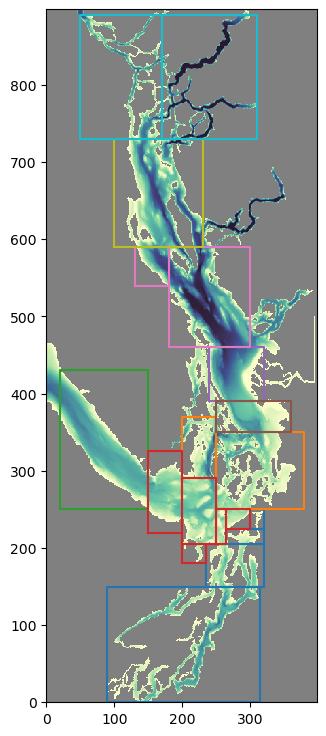

In [163]:
## my boxes
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

## Puget Sound
PS_main = [0, 150, 90, 315]
plot_box(ax, PS_main, 'tab:blue')
PS_AIWB = [150, 205, 235, 320]
plot_box(ax, PS_AIWB, 'tab:blue')
PS_WB = [205, 225, 265, 320]
plot_box(ax, PS_WB, 'tab:blue')
PS_DP = [225, 250, 300, 320]
plot_box(ax, PS_DP, 'tab:blue')

# puget_sound_poly = shapely.geometry.Polygon([(85, 1), (220, 1), (325, 120), (325, 255), (310, 255), (240, 200), (235, 170), (100, 90)])
# plot_poly(ax, puget_sound_poly, 'k')

## Mixing Region
mixing_region1 = [290, 370, 200, 250]
plot_box(ax, mixing_region1, 'tab:orange')
mixing_region2 = [250, 350, 250, 380]
plot_box(ax, mixing_region2, 'tab:orange')

# mixing_region_poly = shapely.geometry.Polygon([(200, 300), (340, 245), (390, 330), (200, 350)])
# plot_poly(ax, mixing_region_poly, 'b')

## Juan de Fuca
JdF1 = [250, 430, 20, 150]
plot_box(ax, JdF1, 'tab:green')
JdF2 = [220, 325, 150, 200]
plot_box(ax, JdF2, 'tab:red')
JdF3 = [205, 290, 200, 250]
plot_box(ax, JdF3, 'tab:red')
JdF4 = [180, 205, 200, 235]
plot_box(ax, JdF4, 'tab:red')
JdF5 = [205, 250, 250, 265]
plot_box(ax, JdF5, 'tab:red')
JdF6 = [225, 250, 265, 300]
plot_box(ax, JdF6, 'tab:red')

## Fraser River Plume
Fraser_plume = [390, 460, 240, 320]
plot_box(ax, Fraser_plume, 'tab:purple')

## Strait of Georgia
SoG_south = [350, 390, 250, 360]
plot_box(ax, SoG_south, 'tab:brown')
SoG_center1 = [460, 590, 180, 300]
plot_box(ax, SoG_center1, 'tab:pink')
SoG_center2 = [540, 590, 130, 180]
plot_box(ax, SoG_center2, 'tab:pink')
SoG_north = [590, 730, 100, 230]
plot_box(ax, SoG_north, 'tab:olive')

## Northern Sounds
sounds = [730, 890, 170, 310]
plot_box(ax, sounds, 'tab:cyan')
straits = [730, 890, 50, 170]
plot_box(ax, straits, 'tab:cyan')

PS_all = [PS_main, PS_AIWB, PS_WB, PS_DP]
MR_all = [mixing_region1, mixing_region2]
JdFE_all = [JdF1]
JdFW_all = [JdF2, JdF3, JdF4, JdF5, JdF6]
FRP_all = [Fraser_plume]
SoGN_all = [SoG_north]
SoGS_all = [SoG_south]
SoGC_all = [SoG_center1, SoG_center2]
SaS_all = [sounds, straits]

In [160]:
meters1_all_mon, prop_all_mon = make_m_and_prop(PS_all, 'fraser_river')

In [164]:
meters_PS, prop_PS = make_m_and_prop(PS_all, 'fraser_river')
meters_MR, prop_MR = make_m_and_prop(MR_all, 'fraser_river')
meters_JdFE, prop_JdFE = make_m_and_prop(JdFE_all, 'fraser_river')
meters_JdFW, prop_JdFW = make_m_and_prop(JdFW_all, 'fraser_river')
meters_FRP, prop_FRP = make_m_and_prop(FRP_all, 'fraser_river')
meters_SoGN, prop_SoGN = make_m_and_prop(SoGN_all, 'fraser_river')
meters_SoGS, prop_SoGS = make_m_and_prop(SoGS_all, 'fraser_river')
meters_SoGC, prop_SoGC = make_m_and_prop(SoGC_all, 'fraser_river')
meters_SaS, prop_SaS = make_m_and_prop(SaS_all, 'fraser_river')

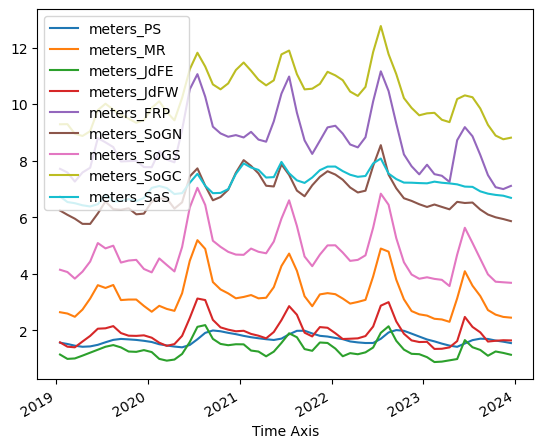

In [171]:
meters_PS.plot(label='meters_PS', c='tab:blue')
meters_MR.plot(label='meters_MR', c='tab:orange')
meters_JdFE.plot(label='meters_JdFE', c='tab:green')
meters_JdFW.plot(label='meters_JdFW', c='tab:red')
meters_FRP.plot(label='meters_FRP', c='tab:purple')
meters_SoGN.plot(label='meters_SoGN', c='tab:brown')
meters_SoGS.plot(label='meters_SoGS', c='tab:pink')
meters_SoGC.plot(label='meters_SoGC', c='tab:olive')
meters_SaS.plot(label='meters_SaS', c='tab:cyan')

plt.legend()

## Stuff

In [13]:
# total_area = make_1d(area, PS_all)

In [14]:
# dim1_2019_mon = make_1d(sum_2019_mon, PS_all)  # dim1 is the sum of all the water in the given regions. is 1d in time for each river
# dim1_2020_mon = make_1d(sum_2020_mon, PS_all)
# dim1_2021_mon = make_1d(sum_2021_mon, PS_all)
# dim1_2022_mon = make_1d(sum_2022_mon, PS_all)
# dim1_2023_mon = make_1d(sum_2023_mon, PS_all)
# dim1_all_mon = xr.concat([dim1_2019_mon, dim1_2020_mon, dim1_2021_mon, dim1_2022_mon, dim1_2023_mon], dim='time')

In [15]:
# meters1_2019_mon = dim1_2019_mon/total_area  # meters1 is the sum of all the water in the region divided by the total area of the regions. is 1d in time for each river
# meters1_2020_mon = dim1_2020_mon/total_area
# meters1_2021_mon = dim1_2021_mon/total_area
# meters1_2022_mon = dim1_2022_mon/total_area
# meters1_2023_mon = dim1_2023_mon/total_area
# meters1_all_mon = xr.concat([meters1_2019_mon, meters1_2020_mon, meters1_2021_mon, meters1_2022_mon, meters1_2023_mon], dim='time')

In [16]:
# totals_2019_mon = dim1_2019_mon.to_array().sum(dim="variable")  # totals is the sum of all freshwater in the region from all the rivers. 1d in time and not sep by river
# totals_2020_mon = dim1_2020_mon.to_array().sum(dim="variable")
# totals_2021_mon = dim1_2021_mon.to_array().sum(dim="variable")
# totals_2022_mon = dim1_2022_mon.to_array().sum(dim="variable")
# totals_2023_mon = dim1_2023_mon.to_array().sum(dim="variable")
# totals_all_mon = xr.concat([totals_2019_mon, totals_2020_mon, totals_2021_mon, totals_2022_mon, totals_2023_mon], dim='time')

In [17]:
# prop_2019_mon = dim1_2019_mon/totals_2019_mon  # prop is the dim1 volume of fw divided by all freshwater, for each river, giving pct contribution of freshwater! 1d in time for each river
# prop_2020_mon = dim1_2020_mon/totals_2020_mon
# prop_2021_mon = dim1_2021_mon/totals_2021_mon
# prop_2022_mon = dim1_2022_mon/totals_2022_mon
# prop_2023_mon = dim1_2023_mon/totals_2023_mon
# prop_all_mon = xr.concat([prop_2019_mon, prop_2020_mon, prop_2021_mon, prop_2022_mon, prop_2023_mon], dim='time')

In [18]:
this_p_var = 'fraser_river'

sum_monthly_mean = np.mean([sum_2019_mon[this_p_var], sum_2020_mon[this_p_var], sum_2021_mon[this_p_var], sum_2022_mon[this_p_var], sum_2023_mon[this_p_var]], axis=0)
sum_5year_mean = np.mean(sum_monthly_mean, axis=0)

In [19]:
sum_monthly_mean.shape

(12, 898, 398)

## Full Field View

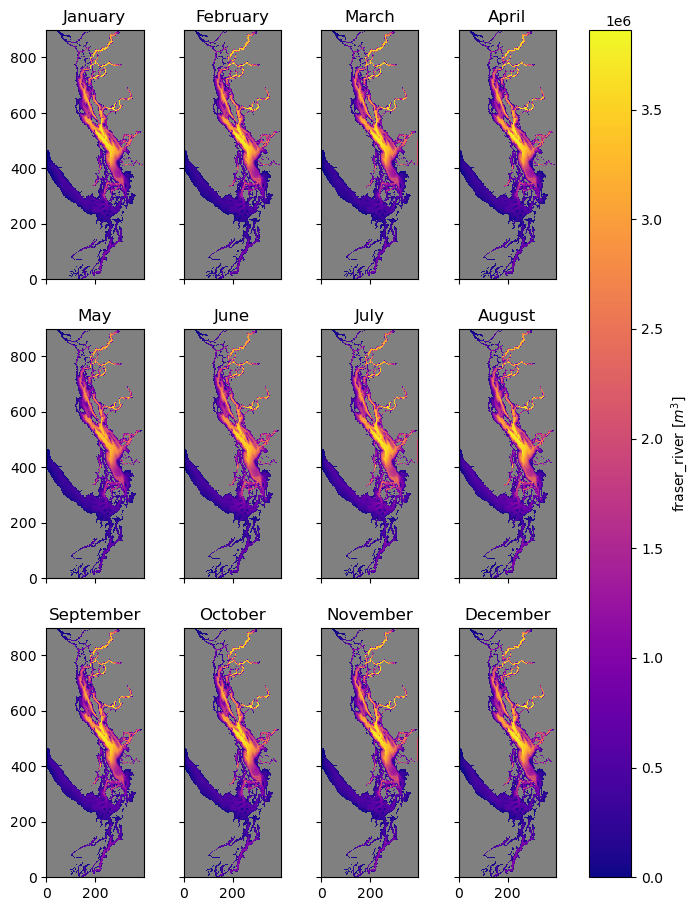

In [20]:
# array = sum_monthly_mean
cmap = mpl.colormaps['plasma']
nrow = 3
ncol = 4
fudge = 0.001

# fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        salinity = np.ma.masked_array(sum_monthly_mean[time_idx], mask=tmask[0])
        colours = ax[row,col].pcolormesh(salinity, vmin=0, cmap=cmap)
        # colours = ax[row,col].pcolormesh(salinity, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
        dtime = pd.to_datetime(sum_2019_mon['time'].values[time_idx])
        ax[row,col].set_title('{}'.format(dtime.month_name()))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label=r'{} [$m^3$]'.format(this_p_var))

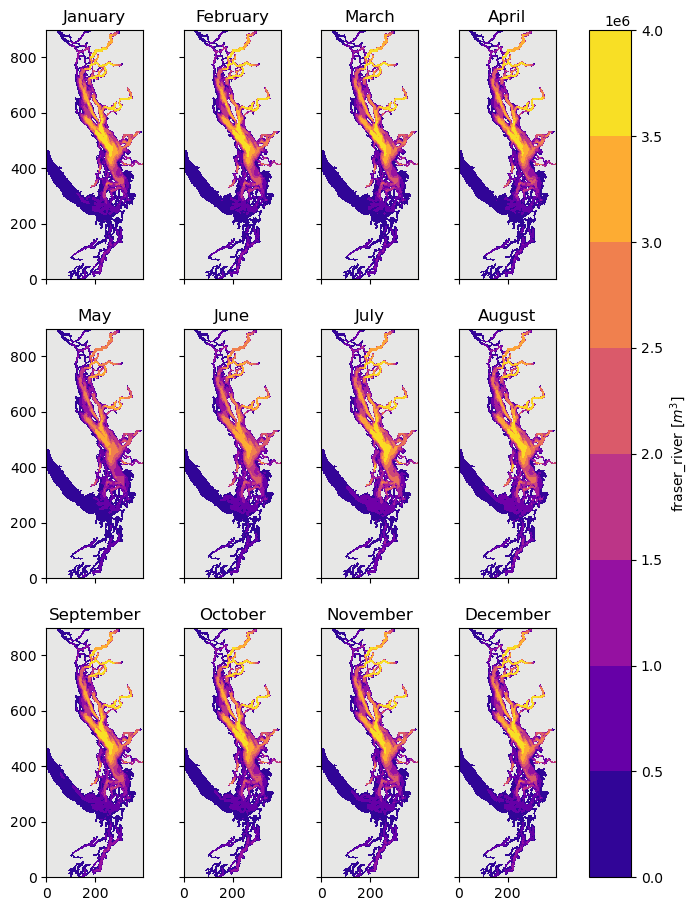

In [21]:
# array = sum_monthly_mean
cmap = mpl.colormaps['plasma']
nrow = 3
ncol = 4
fudge = 0.001

# fname = '{}_all_domain_subset_daily_sum_y{}'.format(p_var, year)
cmap.set_bad('gray')

fig, ax = plt.subplots(nrow,ncol, figsize = (8.5, 11), sharex=True, sharey=True)

for row in np.arange(nrow):
    for col in np.arange(ncol):
        time_idx = row * ncol + col
        fw_vol = np.ma.masked_array(sum_monthly_mean[time_idx], mask=tmask[0])
        ax[row,col].contourf(tmask[0], vmin=0, cmap=cm.gray)
        colours = ax[row,col].contourf(fw_vol, vmin=0, cmap=cmap)
        # colours = ax[row,col].pcolormesh(fw_vol, norm=colors.LogNorm(vmin=fudge), cmap=cmap)
        dtime = pd.to_datetime(sum_2019_mon['time'].values[time_idx])
        ax[row,col].set_title('{}'.format(dtime.month_name()))
        viz_tools.set_aspect(ax[row,col]);

cb = fig.colorbar(colours, ax=ax, label=r'{} [$m^3$]'.format(this_p_var))